Corte Pause Manuela

240183

# Exercise 0
In this initial part I simply define the function used for the CDF inversion sampling method for sampling from an exponential and check if it works correctly by plotting an histogram of the samples together with a exponential distribution of equal $\lambda$

Just as an additional check, I also check the uniformity of the draws from the uniform distribution provided in NumPy

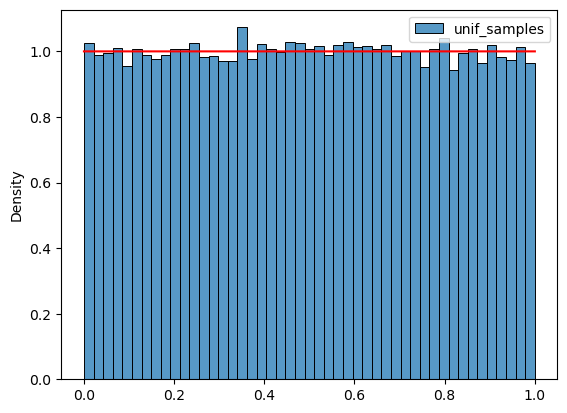

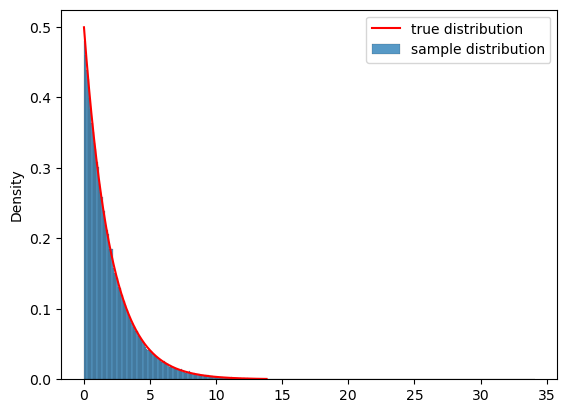

In [1]:
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt


class ValueOutOfRange(Exception):
    pass


def exp_cdf_inverse(p: float, l: float) -> float:
    if p < 0 or p > 1:
        raise ValueOutOfRange(f"Value has to be between 0 and 1 but it's instead {p}")
    return -np.log(p) / l


l = 0.5
sample_size = 100000

gen = np.random.default_rng(seed=41)

unif_samples = gen.uniform(low=0, high=1, size=sample_size)
unif_samples.sort()

exp_samples = []
for p in unif_samples:
    exp_samples.append(exp_cdf_inverse(p, l))

x = np.linspace(0, 1, sample_size)
f, ax = plt.subplots(1)
sns.histplot(unif_samples, stat="density", ax=ax, label="unif_samples")
sns.lineplot(x=x, y=1, ax=ax, color="red")
ax.legend(loc="upper right")

e = st.expon(scale=1 / l)
x = np.linspace(e.ppf(0.001), e.ppf(0.999), sample_size)
f, ax = plt.subplots(1)
sns.histplot(exp_samples, stat="density", ax=ax, label="sample distribution")
sns.lineplot(x=x, y=e.pdf(x), color="red", ax=ax, label="true distribution")
ax.legend(loc="best")


# Exercise 1
The first exercise was about proving the memoryless property of the exponential distribution which says that $P(X>t+s | X>s) = P(X>t)$. The intuition behind the memoryless property is easier to graps when applied to the discrete equivalent of the exponential (for which the memoriless property holds as well): the geometric distribution. If we think of the geometric as tossing a coin until we observe the first head, then the memoryless propertymeans that knowing that we haven't observed an head up to this point is the same thing as starting tossing the coin all over again. 

By repeating the sampling multiple times with different $t$ we can see that the memoryless property holds irrespective of $t$. Obviously with a fixed $\lambda$ it becomes harder and harder to sample points that are greater than $t$ so the curve is less precise in approximating the exponential. Another, more correct, way would have been to have the same number of samples for all experiments when changing $t$ but for large $t$ it was computationally very expensive to repeat the drawing given the high number of samples taken (in any case the code to do soo is provided as a comment).

Similarly we can see that with a increasing $\lambda$ less and less samples are below the threshold t; this is due to the fact that $E[X] = 1/\lambda$ for $X \sim Exp(\lambda)$ and thus the exponential curved is more "squished" toward the origin.

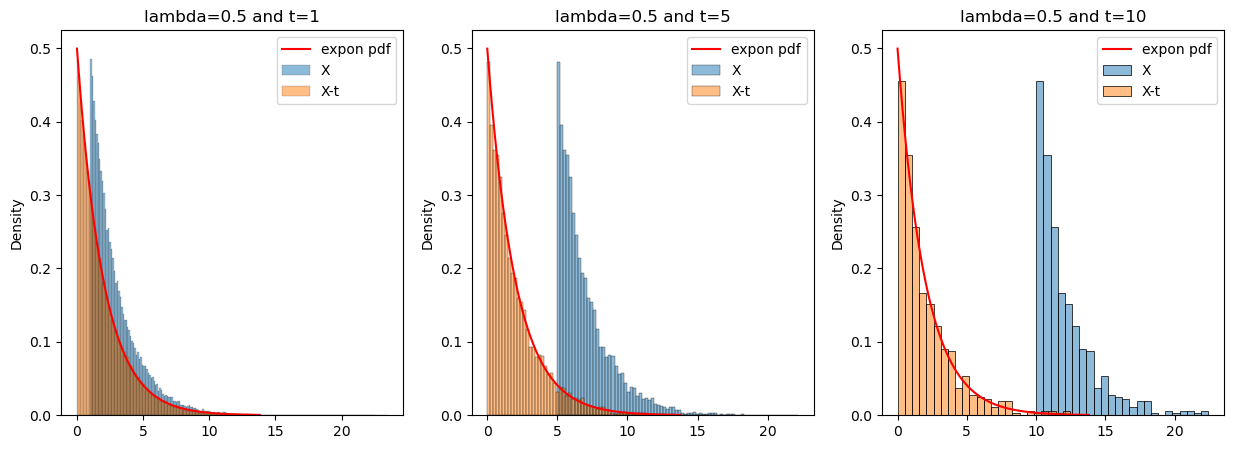

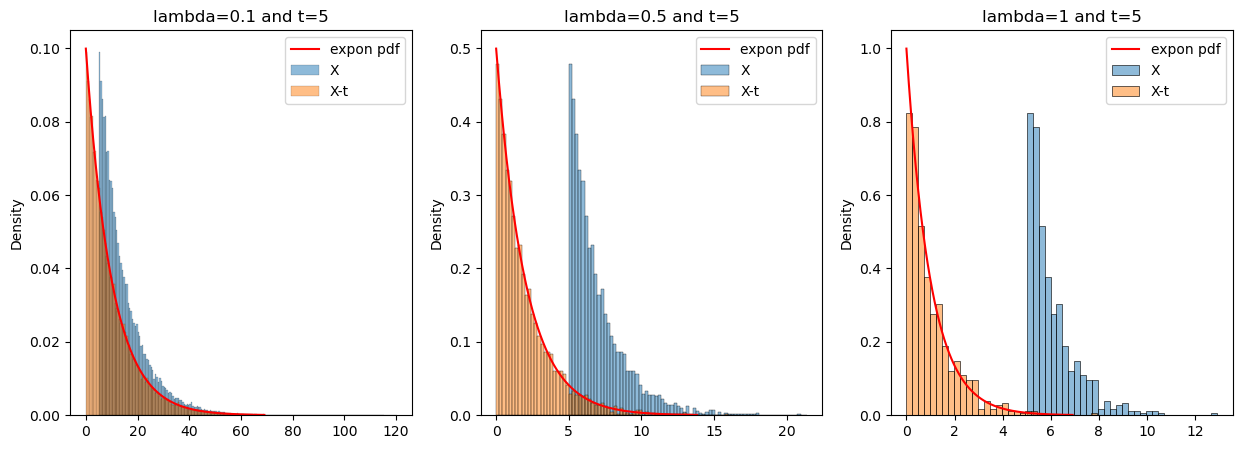

In [2]:
def check_memoriless_property(l, t, sample_size, fig, idx, col):
    exp_1 = []
    exp_2 = []
    # i = 0
    # while i < sample_size:
    #     p = gen.uniform()
    #     e = exp_cdf_inverse(p, l)
    #     if e > t:
    #         # exp_1.append(e)
    #         exp_2.append(e - t)
    #         i += 1

    unif_samples = gen.uniform(size=sample_size)
    for p in unif_samples:
        e = exp_cdf_inverse(p, l)
        if e > t:
            exp_1.append(e)
            exp_2.append(e - t)

    e = st.expon(scale=1 / l)
    x = np.linspace(e.ppf(0.001), e.ppf(0.999), sample_size)

    row = 1
    f = fig.add_subplot(int(f"{row}{col}{idx+1}"))

    sns.lineplot(x=x, y=e.pdf(x), color="red", label="expon pdf")
    sns.histplot(exp_1, alpha=0.5, stat="density", label="X")
    sns.histplot(exp_2, alpha=0.5, stat="density", label="X-t")
    f.set_title(f"lambda={l} and t={t}")
    f.legend(loc="best")


sample_size = 100000
l = 0.5
T = [1, 5, 10]
fig = plt.figure(figsize=(15, 5))
for idx, t in enumerate(T):
    check_memoriless_property(l, t, sample_size, fig, idx, len(T))

L = [0.1, 0.5, 1]
t = 5
fig = plt.figure(figsize=(15, 5))
for idx, l in enumerate(L):
    check_memoriless_property(l, t, sample_size, fig, idx, len(L))


# Exercise 2
In this exercise we want to prove by simulation that drawing N arrivals uniformly in the interval $[0,T]$ is equilavent to draw N exponentially distirbuted interarrival times of average $1/\lambda$ in the interval $[0,T]$. In particular this holds if $\lambda T \approx N$

By sampling the exponentially distributed arrival times we aren't sure we'll be able to sample all $N$ interarrival time before their sum reaches $T$. Below we can see how based on how the interarrival times are drawn we might be "unlucky" and not reach all of our $N$ samples (in this case in the code I simply restarted drawing all $N$ interarrival times from the beginning). This can be more easily seen if we don't respect $\lambda T \approx N$; for example by making $T$ smaller what we are trying to do is sample the same number of arrivals (and thus distributed with the same mean) but in a shorter period of time.

On the other hand, if we keep the same $T$ and $\lambda$ but reduce $N$ we see that the interarrival times aren't distibuted in $[0,T]$ but in $[0, N / \lambda]$


99213.18778869162
49563.881704634194


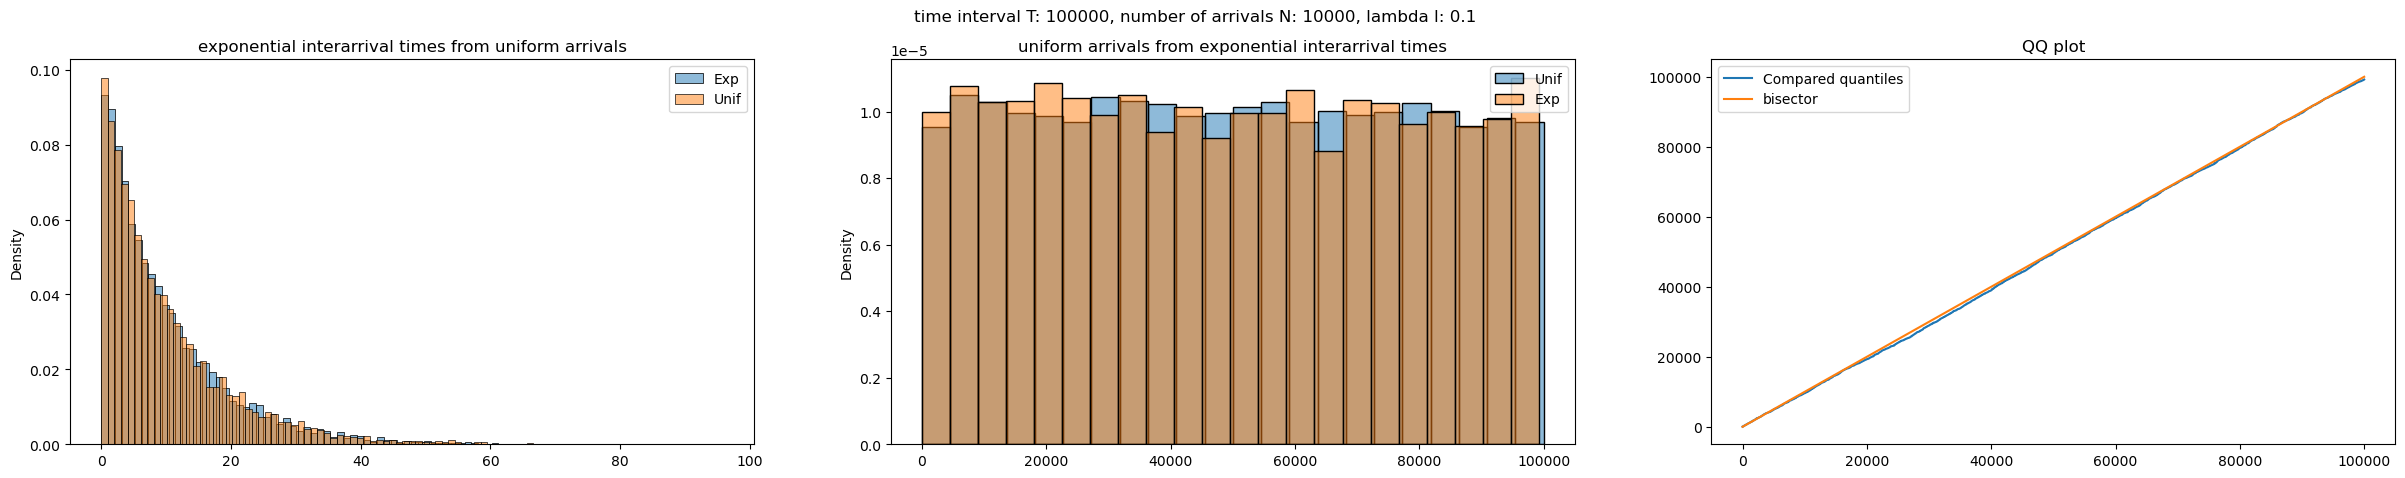

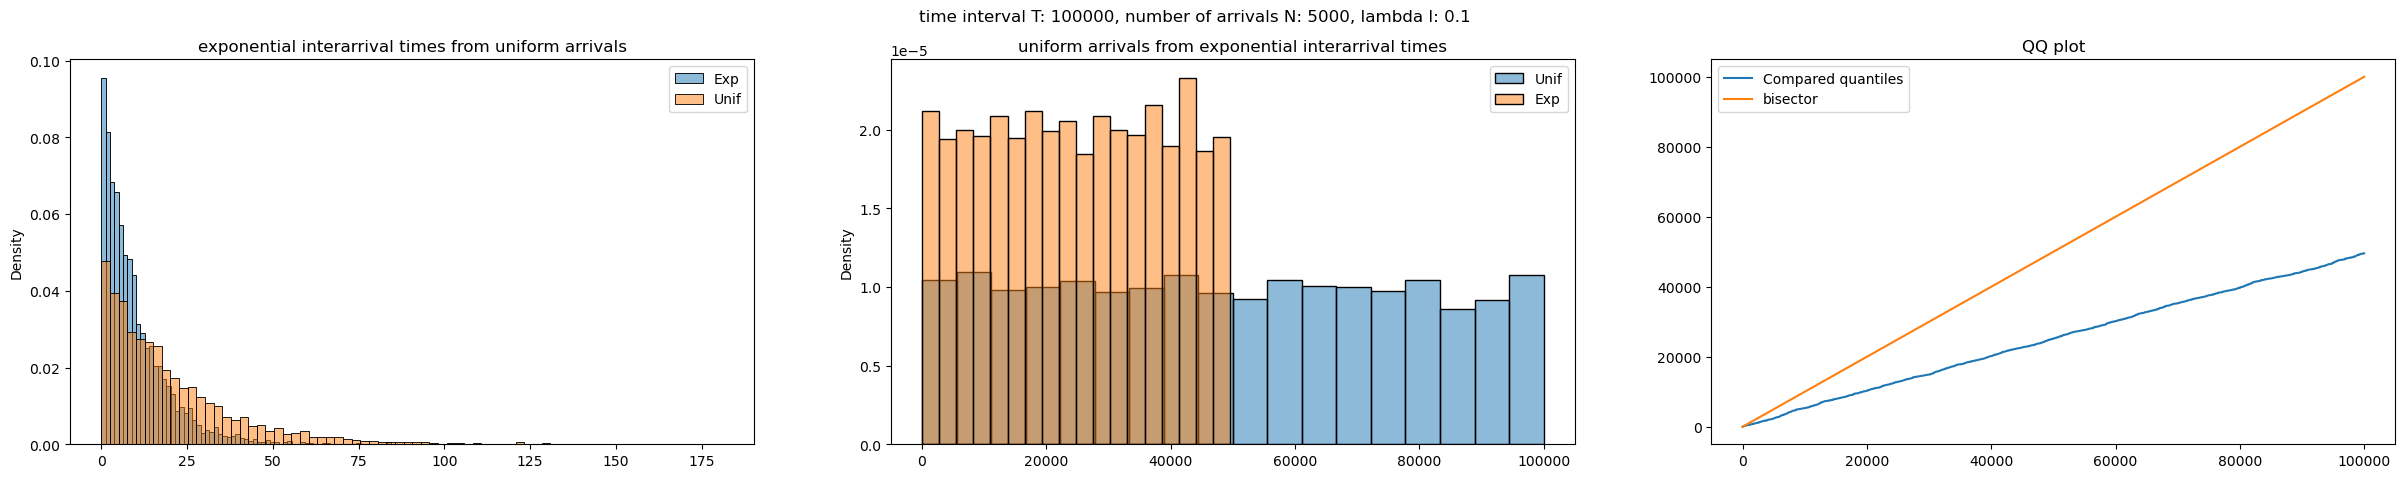

In [3]:
# Another possible way is drawing a drawing a large number and then just taking the first N as the one we care about (with lambda, N and T small)
# Less computationally heavy if you need to throw away your experiment
def poisson_process_samples(T, N, l):
    # Method 1: draw N arrival times uniformly in [0,T] and show these interarrival times are exponential of parameter lambda
    unif_samples = gen.uniform(low=0, high=T, size=N)
    unif_samples = sorted(unif_samples)
    inter_times_unif = []
    prev = unif_samples[0]
    for arr in unif_samples:
        inter_times_unif.append(arr - prev)
        prev = arr

    # Method 2: draw N exponentially distributed interarrival times of average 1/l in interval [0, T] and show the arrival times are uniform in [0, T]
    # N arrival before T N+1 arrival past T
    next_times = []
    inter_times = []
    acc = 0
    i = 0
    while i < N:
        p = gen.uniform()
        sample = exp_cdf_inverse(p, l)
        acc += sample
        inter_times.append(sample)
        next_times.append(acc)
        i += 1
        # print(f"{i}, probability:{p}, timestamp:{acc}")
        if acc > T:
            i = 0
            acc = 0
            inter_times.clear()
            next_times.clear()

    print(max(next_times))

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches((50,10))
    fig.suptitle(f"time interval T: {T}, number of arrivals N: {N}, lambda l: {l}")
    fig.set_size_inches(30, 5)

    f = sns.histplot(inter_times, alpha=0.5, stat="density", ax=ax[0], label="Exp")
    sns.histplot(inter_times_unif, alpha=0.5, stat="density", ax=ax[0], label="Unif")
    f.set_title("exponential interarrival times from uniform arrivals")
    f.legend(loc="best")

    f = sns.histplot(unif_samples, alpha=0.5, stat="density", ax=ax[1], label="Unif")
    sns.histplot(next_times, alpha=0.5, stat="density", ax=ax[1], label="Exp")
    f.set_title("uniform arrivals from exponential interarrival times")
    f.legend(loc="best")

    f = sns.lineplot(x=unif_samples, y=next_times, label="Compared quantiles")
    sns.lineplot(x=range(0, T), y=range(0, T), label="bisector")
    f.set_title("QQ plot")
    f.legend(loc="best")

T = 100000
N = 10000
l = N/T
poisson_process_samples(T, N, l)

T = 100000
N = 5000
l = 0.1
poisson_process_samples(T, N, l)

Add Confidence intervals

In [4]:
n_draws = 200 # draws per experiment
n_exp = 1000 # number of experiments
l = 3 # lambda parameter

draws = np.zeros((n_exp, n_draws))


for i in range(0,n_exp):
    for j in range(0,n_draws):
        draws[i][j] = exp_cdf_inverse(gen.random(), l)

# print(draws)

c_int = np.zeros((n_exp,2))
for i in range(0, n_exp):
    currMean = np.mean(draws[i])
    currSd = np.std(draws[i])
    c_int[i][0] = currMean - 1.96*currSd/np.sqrt(n_draws)
    c_int[i][1] = currMean + 1.96*currSd/np.sqrt(n_draws)

# print(c_int)

trueMean = 1/l
acc = np.zeros((n_exp))
for i in range(0, n_exp):
    if trueMean >= c_int[i][0] and trueMean <= c_int[i][1]:
        acc[i] = 1

print(np.sum(acc)) # around 95% of the times the true mean is in the CI

# Take experiments where true Mean outside CI and plot them


# Oss: to approximate the exponential quite well using asymptotic CI we need a large number of samples because the exponential distribution is quite heavy tailed
# How may sample we need to use the CLT dependes on the distribution we're approximating

933.0
